In [0]:
import os                         # for file locations
import matplotlib.pyplot as plt   # for plotting
import numpy as np                # arrays
import pickle                     # saving python objects
import pandas as pd               # dataframes

RANDOM_STATE = 0

# colours for printing outputs
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [2]:
import gdown
FILE_PATH = 'Epil_features.json.gzip'

if not os.path.exists(FILE_PATH):
    gdown.download('https://drive.google.com/uc?id=143dJfY1_U-p8elbvSzwe0TTHGcDo3PYv', 
                './'+FILE_PATH, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=143dJfY1_U-p8elbvSzwe0TTHGcDo3PYv
To: /content/Epil_features.json.gzip
100%|██████████| 151k/151k [00:00<00:00, 37.7MB/s]


In [3]:
import numpy as np
import pickle           # saving python objects
import pandas as pd     # dataframes

# load features dataframe
feature_df = pd.read_json(FILE_PATH, orient='index', compression = 'gzip')

# display examples of the data
display(feature_df.info())
display(feature_df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 500 non-null    object 
 1   location              500 non-null    object 
 2   file_id               500 non-null    object 
 3   CZ|2_4Hz              500 non-null    float64
 4   CZ|4_8Hz              500 non-null    float64
 5   CZ|8_12Hz             500 non-null    float64
 6   CZ|12_30Hz            500 non-null    float64
 7   CZ|30_70Hz            500 non-null    float64
 8   CZ|Ratio_3_12/2_30Hz  500 non-null    float64
 9   CZ|D6_mean            500 non-null    float64
 10  CZ|D5_mean            500 non-null    float64
 11  CZ|D4_mean            500 non-null    float64
 12  CZ|D3_mean            500 non-null    float64
 13  CZ|D2_mean            500 non-null    float64
 14  CZ|D1_mean            500 non-null    float64
 15  CZ|D6_std             5

None

,class,location,file_id,CZ|2_4Hz,CZ|4_8Hz,CZ|8_12Hz,CZ|12_30Hz,CZ|30_70Hz,CZ|Ratio_3_12/2_30Hz,CZ|D6_mean,CZ|D5_mean,CZ|D4_mean,CZ|D3_mean,CZ|D2_mean,CZ|D1_mean,CZ|D6_std,CZ|D5_std,CZ|D4_std,CZ|D3_std,CZ|D2_std,CZ|D1_std,CZ|D6_ratio,CZ|D5_ratio,CZ|D4_ratio,CZ|D3_ratio,CZ|D2_ratio,CZ|D1_ratio,CZ|D6_mean_abs,CZ|D5_mean_abs,CZ|D4_mean_abs,CZ|D3_mean_abs,CZ|D2_mean_abs,CZ|D1_mean_abs,CZ|D6_LSWT,CZ|D5_LSWT,CZ|D4_LSWT,CZ|D3_LSWT,CZ|D2_LSWT,CZ|D1_LSWT
0,baseline,intracranial epileptogenic zone,F001,77.429564,28.734279,13.102026,2.467909,0.462172,0.138219,-1.758529,3.689356,0.572214,0.401766,-0.008293,-0.041443,94.954945,77.076934,36.437346,18.901216,6.525675,2.479045,1.272058,1.147393,0.756706,0.877359,0.631333,0.362810,76.722313,60.313528,28.409123,14.772764,5.266416,1.910710,0.000000,6.427250,5.613190,5.805773,4.749819,3.665018
1,baseline,intracranial epileptogenic zone,F002,1060.585071,480.018796,201.886582,29.713494,4.070126,0.140057,-43.528777,5.563645,-5.458138,-1.311734,0.120496,-0.002805,399.209789,281.923087,151.139973,67.289651,18.696915,3.012844,1.878949,0.824373,0.906137,0.687953,0.514802,0.208105,281.597393,149.869616,81.999218,31.116812,8.462824,1.761159,0.000000,8.241056,7.388935,7.770027,8.062119,8.020356
2,baseline,intracranial epileptogenic zone,F003,316.076591,186.372298,135.970946,20.841888,2.781560,0.148809,7.140095,-10.223593,1.088205,-1.555793,-0.034026,-0.034373,357.861759,132.001620,118.527127,55.385295,15.882118,4.972672,2.901753,0.533720,1.222865,0.809146,0.499067,0.210005,298.635855,102.915688,87.018413,39.403208,10.376156,2.179047,7.534104,0.000000,7.412203,6.336933,7.197397,7.170449
3,baseline,intracranial epileptogenic zone,F004,213.966621,91.338657,34.191639,3.157286,0.573759,0.064002,-15.857898,-3.700006,3.257209,-0.135347,0.081712,-0.032627,165.928055,119.045182,59.769483,22.377317,6.419182,2.324330,1.400790,1.052269,0.839701,0.687769,0.516294,0.365782,127.731141,91.185066,45.580184,17.377872,4.953816,1.812019,0.000000,6.422032,7.582963,6.947882,7.086014,6.950912
4,baseline,intracranial epileptogenic zone,F005,973.296659,385.347164,218.880920,47.891201,7.560384,0.183348,-21.433089,-34.709688,5.766435,-3.044324,0.069729,0.081691,346.795965,216.454349,152.238202,75.145144,28.542184,6.026236,1.648172,0.853625,1.051711,0.801236,0.625299,0.198041,270.422836,164.074428,113.995056,52.705751,17.566081,3.478807,8.055723,0.000000,8.726303,8.031105,8.460379,8.480473


In [4]:
feature_df['location'].unique()

array(['intracranial epileptogenic zone', 'intracranial hippocampus',
       'surface'], dtype=object)

In [5]:
# select only intracranial EEG
feature_reduced = feature_df[feature_df.location != 'surface']
feature_reduced['location'].unique()

array(['intracranial epileptogenic zone', 'intracranial hippocampus'],
      dtype=object)

## Splitting Data

We need to split the data up into an array containing the feature data and an array of the class labels.



In [6]:
import sklearn
sklearn.__version__

'0.22.2.post1'

### Datax

Getting the feature array is pretty easy. All we need do is remove the other columns I made referring to the class, file_id and location of the electrodes as these will not be used as features of the signals.

Scikit-learn accepts numpy arrays so we need to change our pandas dataframe to an array. This is simple enough as we just need to use `.values`

In [7]:
feature_df_drop = feature_df.drop(['class', 'file_id', 'location'], axis='columns')
data_x = feature_df_drop.values

data_x

array([[  77.42956361,   28.73427904,   13.10202554, ...,    5.80577268,
           4.74981903,    3.66501809],
       [1060.58507118,  480.01879575,  201.886582  , ...,    7.77002745,
           8.0621192 ,    8.02035555],
       [ 316.07659124,  186.37229784,  135.97094565, ...,    6.33693273,
           7.19739712,    7.17044911],
       ...,
       [  81.55428714,   49.70403992,   75.17451777, ...,    6.57245791,
           5.42744447,    6.1220055 ],
       [  89.63214378,   96.72602516,   93.09894163, ...,    0.        ,
           5.31796381,    4.56826703],
       [ 111.93187763,   61.40272274,   76.48485277, ...,    0.        ,
           5.6456761 ,    6.2556254 ]])

##Data y
The most simple method is to use a label encoder, which encodes labels with value between 0 and n_classes-1. 

In [8]:
display(feature_df['class'].value_counts())

baseline    400
seizure     100
Name: class, dtype: int64

In [9]:
from sklearn.preprocessing import LabelEncoder

# create condition(group) array
class_series = feature_df['class']

# make a label encoder
le = LabelEncoder()
# change the string labels to ints
data_y = le.fit_transform(class_series)

# get the unique labels
labels = list(class_series.unique())
# print out the labels and their new codes
for i, code in enumerate(list(le.transform(labels))):
    print(labels[i] + ': ' + str(code))
    
data_y[:5]

baseline: 0
seizure: 1


array([0, 0, 0, 0, 0])

### Training and Test Data

Data is split into training and test sets that have the same class proportions as the original data. This is because later when we fit out classification model to predict a class in the data, we want to compare predictions to some true labels in a separate group of data (the test set) to give an unbiased performance evaluation of our model before we use it in the real world. Balancing the information loss in the training set and estimation of a models generalization error requires the size of the data to be taken into consideration. As we are witholding data the algorithm could learn from for the test set we don't want to withhold too much information but the smaller the test set, the more inaccurate the estimation of the generalization error<sup>1</sup>.

To split the data we will use the train_test_split function. Note that this function automatically shuffles the data before splitting. We fix a random_state parameter, as we will for a number of later functions, to fix the internal pseudo-random number generator used for shuffling the datasets to ensure our results are reproducible.

Lets start by going back to a simple label encoded y data to encode seizure and non-seizure data and we will remove the surface electrodes.



In [10]:
# select only intracranial EEG
feature_reduced = feature_df[feature_df.location != 'surface']
# drop the columns which are not feature variables
feature_reduced_drop = feature_reduced.drop(['class', 'file_id', 'location'], axis='columns')
# change to an array
data_x = feature_reduced_drop.values
# change the string labels to ints
data_y = le.fit_transform(feature_reduced['class'])

print(color.BOLD+'Feature DataFrame'+color.END)
display(data_x.shape)
print(color.BOLD+'Target DataFrame'+color.END)
display(data_y.shape)

Feature DataFrame


(300, 36)

Target DataFrame


(300,)

In [11]:
from sklearn.model_selection import train_test_split
TEST_SIZE = 0.1

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, 
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=TEST_SIZE, 
                                                  random_state=RANDOM_STATE)

print(color.BOLD+color.UNDERLINE+'Feature DataFrame'+color.END)
print('Training size: ' + str(X_train.shape))
print('Validation size: ' + str(X_val.shape))
print('Test size: ' + str(X_test.shape))
print(color.BOLD+color.UNDERLINE+'\nTarget DataFrame'+color.END)
print('Training size: ' + str(y_train.shape))
print('Validation size: ' + str(y_val.shape))
print('Test size: ' + str(y_test.shape))

Feature DataFrame
Training size: (243, 36)
Validation size: (27, 36)
Test size: (30, 36)

Target DataFrame
Training size: (243,)
Validation size: (27,)
Test size: (30,)


In [12]:
def get_proportions(data):

    counts = pd.DataFrame(np.unique(data, return_counts=True), index = ['Class_ID', 'Counts']).T
    counts['Percent'] = (counts['Counts']/counts['Counts'].sum()).round(2)*100
    counts = counts.set_index('Class_ID')
    return counts

    
print(color.BOLD+color.UNDERLINE+'Training DataFrame'+color.END)
display(get_proportions(y_train))
print(color.BOLD+color.UNDERLINE+'\nTest DataFrame'+color.END)
display(get_proportions(y_test))

Training DataFrame


,Counts,Percent
Class_ID,,
0,169,70.0
1,74,30.0



Test DataFrame


,Counts,Percent
Class_ID,,
0,17,57.0
1,13,43.0


In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)

In [14]:
feature_list = list(feature_reduced_drop.columns)
feature_list

['CZ|2_4Hz',
 'CZ|4_8Hz',
 'CZ|8_12Hz',
 'CZ|12_30Hz',
 'CZ|30_70Hz',
 'CZ|Ratio_3_12/2_30Hz',
 'CZ|D6_mean',
 'CZ|D5_mean',
 'CZ|D4_mean',
 'CZ|D3_mean',
 'CZ|D2_mean',
 'CZ|D1_mean',
 'CZ|D6_std',
 'CZ|D5_std',
 'CZ|D4_std',
 'CZ|D3_std',
 'CZ|D2_std',
 'CZ|D1_std',
 'CZ|D6_ratio',
 'CZ|D5_ratio',
 'CZ|D4_ratio',
 'CZ|D3_ratio',
 'CZ|D2_ratio',
 'CZ|D1_ratio',
 'CZ|D6_mean_abs',
 'CZ|D5_mean_abs',
 'CZ|D4_mean_abs',
 'CZ|D3_mean_abs',
 'CZ|D2_mean_abs',
 'CZ|D1_mean_abs',
 'CZ|D6_LSWT',
 'CZ|D5_LSWT',
 'CZ|D4_LSWT',
 'CZ|D3_LSWT',
 'CZ|D2_LSWT',
 'CZ|D1_LSWT']

In [15]:
x_axis_label = 'CZ|D1_ratio'
y_axis_label = 'CZ|D2_ratio'

reduced_array = X_train_scale[:,[feature_list.index(x_axis_label),feature_list.index(y_axis_label)]]
reduced_df = pd.DataFrame(reduced_array, columns=[x_axis_label, y_axis_label])

reduced_df.head()

,CZ|D1_ratio,CZ|D2_ratio
0,0.614533,0.007356
1,-1.367899,-0.728042
2,1.384150,0.588297
3,0.754261,0.142999
4,0.308568,0.976768


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


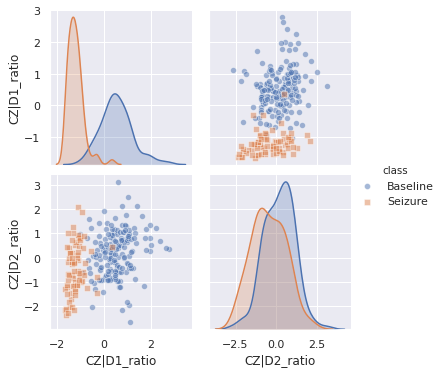

In [16]:
import seaborn as sns; sns.set(color_codes=True)

def plot_pairplot(data_x, data_y):

    data_plot = data_x.copy()
    data_plot['class'] = np.vectorize({0:'Baseline', 1:'Seizure'}.get)(data_y)
    sns.pairplot(data_plot, 
                 hue = 'class', 
                 hue_order = ['Baseline','Seizure'],
                 markers=["o", "s"], 
                 plot_kws=dict(alpha = 0.5))
    plt.show()
    
plot_pairplot(reduced_df, y_train)

### Under-Sampling

**Resample**

A fast way to balance the data is just to randomly select a subset of the data for each class so they have the number of datapoints found in the smallest class.

First lets do this using the scikit-learn library


Before Resample
Counter({0: 169, 1: 74})


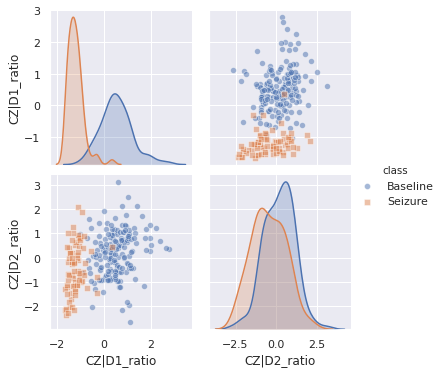

After Resample
Counter({1: 74, 0: 74})


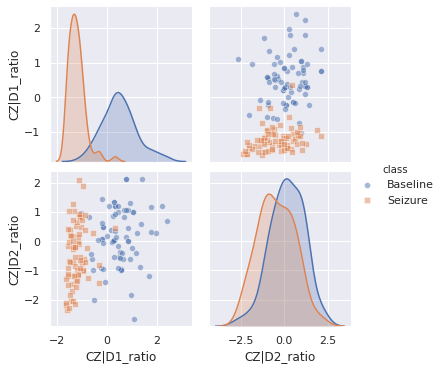

In [17]:
from sklearn.utils import resample
from collections import Counter

print(color.UNDERLINE + 'Before Resample' + color.END)
print(Counter(y_train))
plot_pairplot(reduced_df, y_train)

print(color.UNDERLINE + 'After Resample' + color.END)
data_x_downsampled, data_y_downsampled = resample(reduced_df[y_train == 0],
                                                  y_train[y_train == 0],
                                                  replace=True,
                                                  n_samples=reduced_df[y_train == 1].shape[0],
                                                  random_state=123)

data_x_bal = np.vstack((reduced_df[y_train == 1], data_x_downsampled))
data_y_bal = np.hstack((y_train[y_train == 1], data_y_downsampled))
print(Counter(data_y_bal))

plot_pairplot(pd.DataFrame(data_x_bal, columns = reduced_df.columns), 
              pd.DataFrame(data_y_bal))

**RandomUnderSampler**

RandomUnderSampler is part of the Imblearn package, which allows for a lot of techniques for working with imballanced data.

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Before Resample
Counter({0: 169, 1: 74})


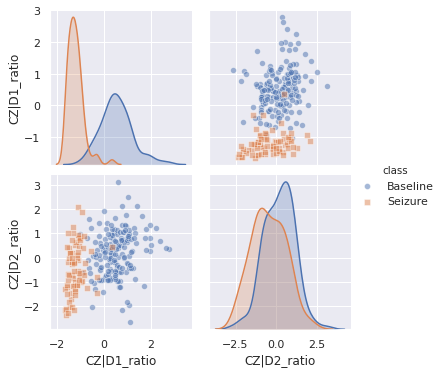

After Resample
Counter({0: 74, 1: 74})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


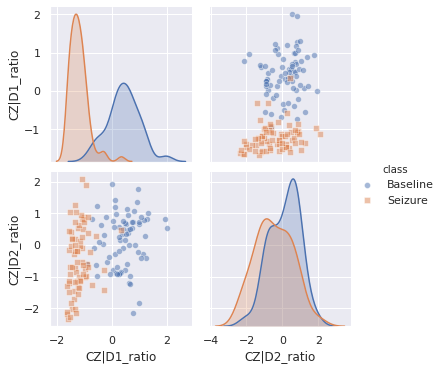

In [18]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

def imblearn_sample(sampler, data_x, data_y):

    print(color.UNDERLINE + 'Before Resample' + color.END)
    print(Counter(data_y))
    plot_pairplot(data_x, data_y)

    print(color.UNDERLINE + 'After Resample' + color.END)
    data_x_downsampled, data_y_downsampled = sampler.fit_resample(data_x,
                                                                data_y)
    print(Counter(data_y_downsampled))

    plot_pairplot(pd.DataFrame(data_x_downsampled, columns = data_x.columns), 
                  pd.DataFrame(data_y_downsampled))
    
imblearn_sample(RandomUnderSampler(random_state=123), reduced_df, y_train)

### Over-Sampling

**RandomOverSampler**

Data can be oversampled easily by randomly sampling from minority classes with replacement to duplicate original samples. 

Before Resample
Counter({0: 169, 1: 74})


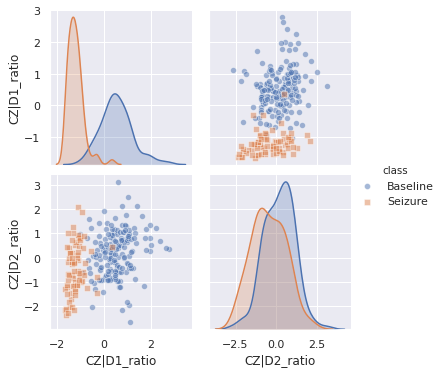

After Resample
Counter({0: 169, 1: 169})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


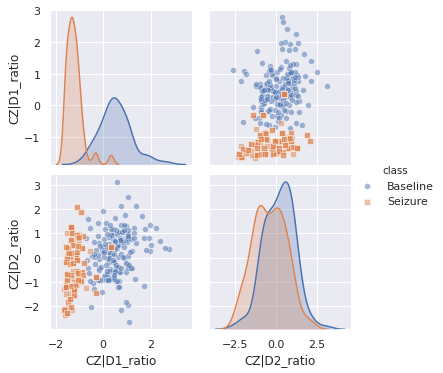

In [19]:
from imblearn.over_sampling import RandomOverSampler

imblearn_sample(RandomOverSampler(random_state=123), reduced_df, y_train)

SMOTE
Before Resample
Counter({0: 169, 1: 74})


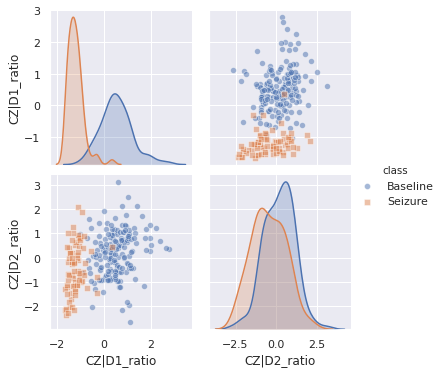

After Resample
Counter({0: 169, 1: 169})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


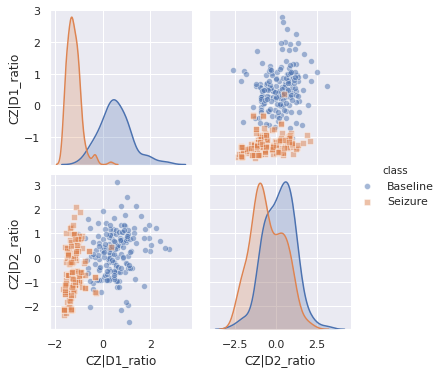

ADASYN
Before Resample
Counter({0: 169, 1: 74})


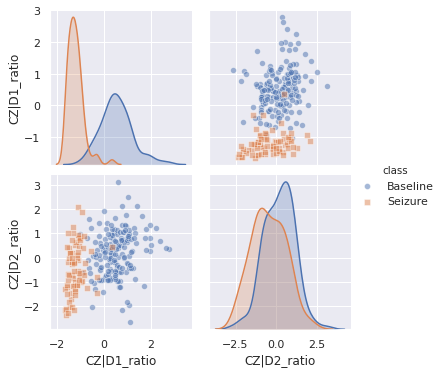

After Resample
Counter({0: 169, 1: 167})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


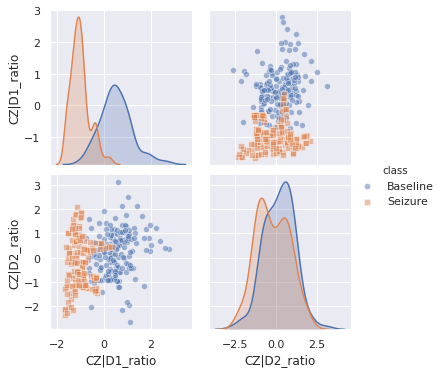

SMOTE with Edited Nearest Neighbor
Before Resample
Counter({0: 169, 1: 74})


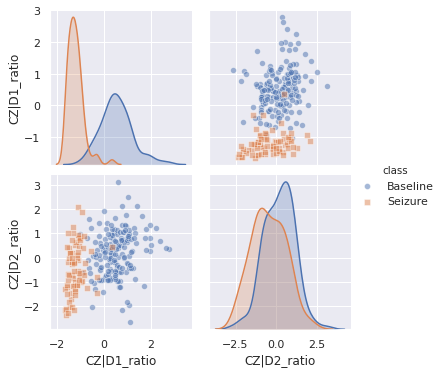

After Resample
Counter({0: 151, 1: 148})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

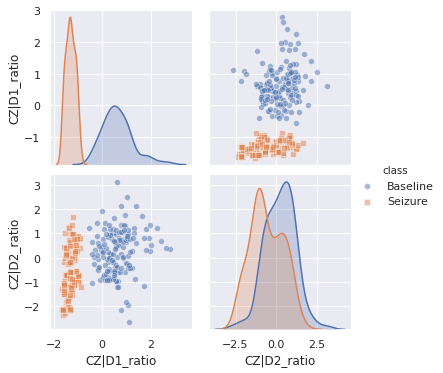

SMOTE with Tomek links
Before Resample
Counter({0: 169, 1: 74})


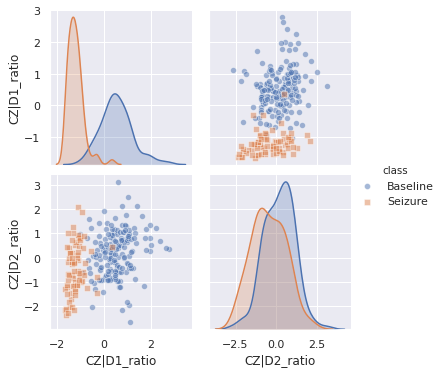

After Resample
Counter({0: 166, 1: 166})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


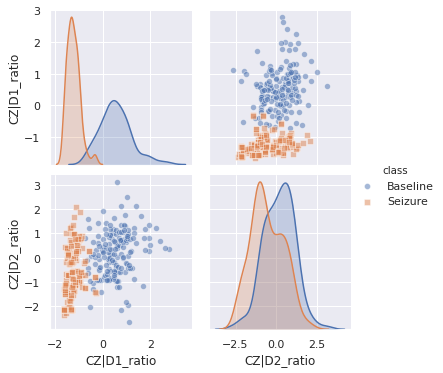

In [20]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek

print(color.BOLD+color.UNDERLINE+'SMOTE'+color.END)
imblearn_sample(SMOTE(random_state=123), reduced_df, y_train)
print(color.BOLD+color.UNDERLINE+'ADASYN'+color.END)
imblearn_sample(ADASYN(random_state=123), reduced_df, y_train)
print(color.BOLD+color.UNDERLINE+'SMOTE with Edited Nearest Neighbor'+color.END)
imblearn_sample(SMOTEENN(random_state=123), reduced_df, y_train)
print(color.BOLD+color.UNDERLINE+'SMOTE with Tomek links'+color.END)
imblearn_sample(SMOTETomek(random_state=123), reduced_df, y_train)

***BINARY CLASSIFICATION***

## Logistic Regression


In [21]:
from sklearn.linear_model import LogisticRegression

reg = LogisticRegression(C=100., 
                         solver='liblinear',
                         random_state=RANDOM_STATE)

reg.fit(X_train_scale, y_train)

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

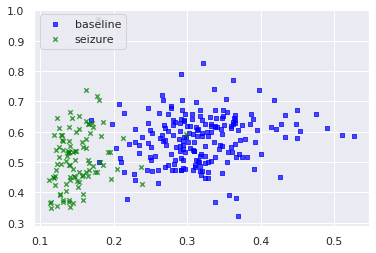

In [22]:
from mlxtend.plotting import category_scatter

x_axis_label = 'CZ|D1_ratio'
y_axis_label = 'CZ|D2_ratio'

fig = category_scatter(x=x_axis_label, y=y_axis_label, label_col='class', 
                       data=feature_reduced, legend_loc='upper left')

feature_list = list(feature_reduced_drop.columns)
vis_data = X_train_scale[:,[feature_list.index(x_axis_label),
                          feature_list.index(y_axis_label)]]

/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


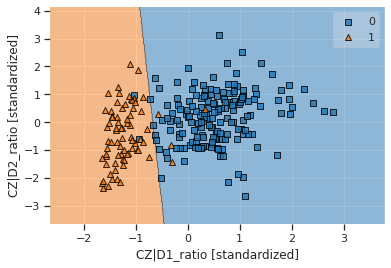

In [23]:
from mlxtend.plotting import plot_decision_regions

reg.fit(vis_data, y_train)

plot_decision_regions(vis_data,
                      y_train,
                      clf = reg)

plt.xlabel(x_axis_label + ' [standardized]') 
plt.ylabel(y_axis_label + ' [standardized]')
plt.show()

/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())
/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())
/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


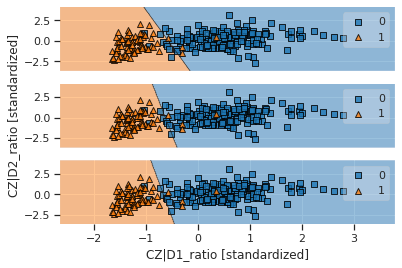

In [24]:
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True)

for i, c in enumerate([0.1, 1, 10]):
    reg = LogisticRegression(C=c, solver='liblinear',random_state=RANDOM_STATE)

    reg.fit(vis_data, y_train)

    plot_decision_regions(vis_data,
                          y_train,
                          clf = reg,
                          ax = axes[i])
    axes[i].get_xaxis().set_visible(False)

axes[2].get_xaxis().set_visible(True)
plt.xlabel(x_axis_label + ' [standardized]') 
axes[1].set_ylabel(y_axis_label + ' [standardized]')
plt.savefig('log_change_reg.png')
plt.show()

In [25]:
from sklearn.pipeline import Pipeline

pipe_reg = Pipeline([('scl', StandardScaler()),
                     ('clf', LogisticRegression(C=100, 
                                                solver='liblinear',
                                                class_weight='balanced',
                                                random_state=RANDOM_STATE))])

pipe_reg

Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 LogisticRegression(C=100, class_weight='balanced', dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=0,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [26]:
pipe_reg.fit(X_train, y_train)
print('Validation Accuracy: %.3f' % pipe_reg.score(X_val, y_val))

Validation Accuracy: 1.000


In [27]:
log_predicted = pipe_reg.predict(X_val)
log_predicted

array([0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 0])

In [28]:
y_val


array([0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 0])

## Support Vector Machine (SVM)


In [29]:
from sklearn.svm import SVC

pipe_svc_linear = Pipeline([('scl', StandardScaler()),
                            ('clf', SVC(C=100,
                                        kernel='linear',
                                        class_weight = 'balanced', 
                                        random_state=RANDOM_STATE))])

pipe_svc_linear

Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 SVC(C=100, break_ties=False, cache_size=200,
                     class_weight='balanced', coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='scale',
                     kernel='linear', max_iter=-1, probability=False,
                     random_state=0, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


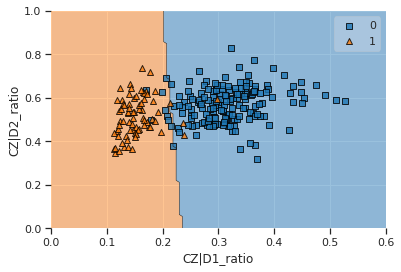

In [30]:
from mlxtend.plotting import plot_decision_regions

vis_data = X_train[:,[feature_list.index(x_axis_label),
                      feature_list.index(y_axis_label)]]

pipe_svc_linear.fit(vis_data, y_train)

plot_decision_regions(vis_data,
                      y_train,
                      clf = pipe_svc_linear)

plt.xlabel(x_axis_label) 
plt.ylabel(y_axis_label)
plt.xlim(0,.6)
plt.ylim(0,1.)

plt.savefig('svm_linear_boundary.png')
plt.show()

/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


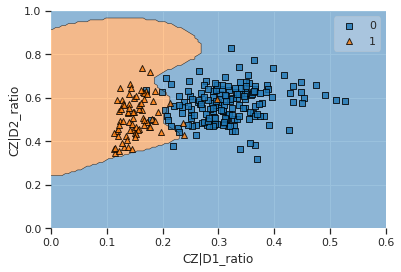

In [31]:
pipe_svc_rbf = Pipeline([('scl', StandardScaler()),
                         ('clf', SVC(C=100,
                                     kernel='rbf',
                                     class_weight = 'balanced', 
                                     random_state=RANDOM_STATE))])

pipe_svc_rbf.fit(vis_data, y_train)

plot_decision_regions(vis_data,
                      y_train,
                      clf = pipe_svc_rbf)

plt.xlabel(x_axis_label) 
plt.ylabel(y_axis_label)
plt.xlim(0,.6)
plt.ylim(0,1.)

plt.savefig('svm_rbf_boundary.png')
plt.show()

In [32]:
pipe_svc_rbf.fit(X_train, y_train)
print('Validation Accuracy: %.3f' % pipe_svc_rbf.score(X_val, y_val))

Validation Accuracy: 1.000


###DECISION TREE

In [33]:
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier(criterion='gini',
                            max_depth = 1,
                            random_state=RANDOM_STATE)

DT

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [34]:
!pip install graphviz

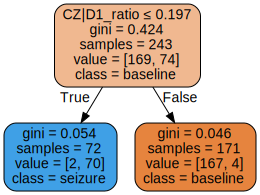

In [35]:
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data
import graphviz

DT.fit(vis_data, y_train)
dot_data = export_graphviz(DT, out_file=None, 
                     feature_names=[x_axis_label, y_axis_label],  
                     class_names=feature_reduced['class'].unique(),  
                     filled=True, rounded=True,  
                     special_characters=True)  

# Save it
graph = graph_from_dot_data(dot_data)
graph.write_png('binary_split.png')

# Show it
graphviz.Source(dot_data)

/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


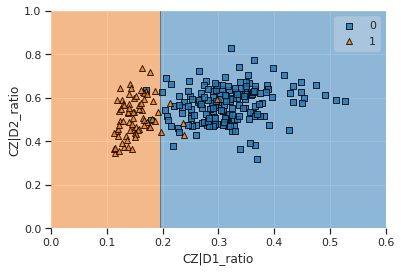

In [36]:
plot_decision_regions(vis_data,
                      y_train,
                      clf = DT)

plt.xlabel(x_axis_label) 
plt.ylabel(y_axis_label)
plt.xlim(0,.6)
plt.ylim(0,1.)
plt.show()

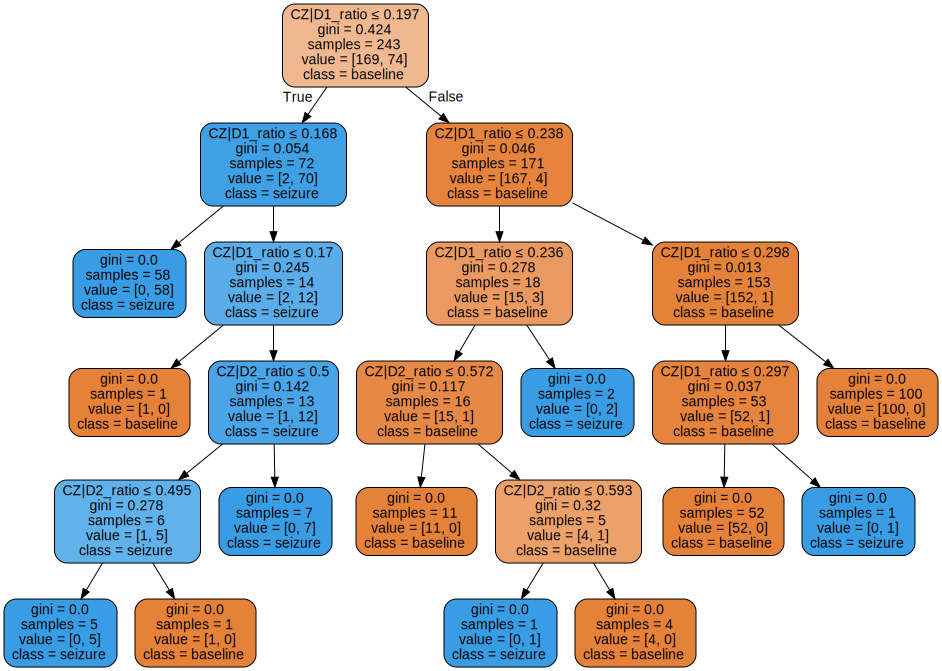

In [37]:
DT = DecisionTreeClassifier(criterion='gini',
                            max_depth = None,
                            random_state=RANDOM_STATE)
DT.fit(vis_data, y_train)

dot_data = export_graphviz(DT, out_file=None, 
                     feature_names=[x_axis_label, y_axis_label],  
                     class_names=feature_reduced['class'].unique(),  
                     filled=True, rounded=True,  
                     special_characters=True)  

# Save it
graph = graph_from_dot_data(dot_data)
graph.write_png('multi_split.png')

# Show it
graphviz.Source(dot_data)

/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


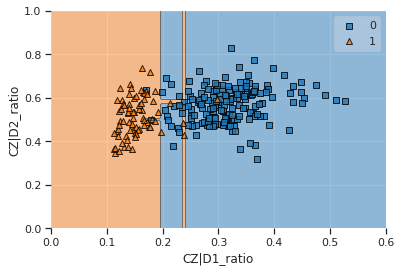

In [38]:
plot_decision_regions(vis_data,
                      y_train,
                      clf = DT)

plt.xlabel(x_axis_label) 
plt.ylabel(y_axis_label)
plt.xlim(0,.6)
plt.ylim(0,1.)
plt.show()